# Introduction

In this tutorial, we will learn to model online forums. 

In [16]:
devtools::load_all()
install.packages("igraph")

Loading genthreads
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel

Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘igraph’

The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Installing package into ‘/home/alumbreras/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)


## Vector representation of a tree

We will first learn how to represent the structure and dynamics of an online conversations in a very simple way. Imagine that we have this graphical representation:

In [7]:
load(toy_igraph)
plot(toy_igraph)

ERROR: Error in load(toy_igraph): objeto 'toy_igraph' no encontrado


We will create its **parents vector**. The parents vector is a vector $\boldsymbol{\pi} = (\pi_1,...,\pi_2)$ where $\pi_t$ contains the parent of node $t$. Our package contains a function that plots the tree corresponding to a parents vector. For the above tree, we would have:

In [12]:
parents <- c(1,2,2,3,4)
plot.tree.nicely(parents)  

ERROR: Error in plot.tree.nicely(parents): no se pudo encontrar la función "plot.tree.nicely"


Loading genthreads


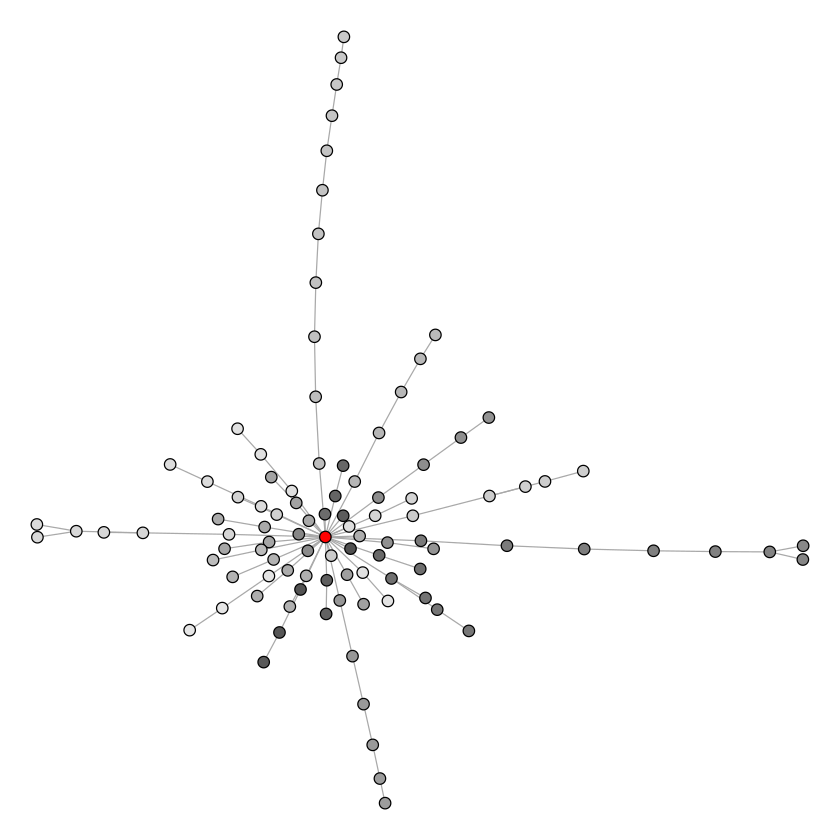

In [17]:
devtools::load_all()

alpha <- 0.0
beta <- 1
tau <- 0.2
ntrees <- 100

# Generate an plot synthetic tree ----------------------------------------------
parents <- gen.parentsvector.Gomez2013(ntrees, alpha, beta, tau) # generate
plot.tree.nicely(parents)    

In [ ]:

# Generate N synthetic trees (and plot some) -----------------------------------
ntrees <- 1000
parents <- replicate(ntrees,
                     gen.parentsvector.Gomez2013(n, alpha, beta, tau), 
                     simplify = FALSE)
par(mfrow = c(3,3))
sapply(1:9, function(idtree) plot.tree.nicely(parents[[idtree]])) # Plot some

In [ ]:

# Estimate paremeters ----------------------------------------------------------

# Store in dataframe format. 
# Each line contains the post id, the chosen parent
# and the features of its parent (popularity, lag, root) at the 
# moment (t) of that choice.
df.trees <- all_parents_to_dataframe(parents)        

# Grid search of one parameter given the other two 
# This is useful to see the shape of the likelihood around the MLE.
par(mfrow = c(3,1))
alpha_grid <- seq(0.5,2, by = 0.01)
like <- rep(NA, length(alpha_grid))
for(i in 1:length(alpha_grid)){
  like[i] <- likelihood_Gomez2013(df.trees, alpha_grid[i], beta, tau)
}
plot(alpha_grid, like, xlab = 'alpha')
abline(v=alpha, col = 'blue')

beta_grid <- seq(0,10, by = 0.1)
like <- rep(NA, length(beta_grid))
for(i in 1:length(beta_grid)){
  like[i] <- likelihood_Gomez2013(df.trees, alpha=alpha, beta_grid[i], tau)
}
plot(beta_grid, like, xlab = 'beta')
abline(v=beta, col = 'blue')

tau_grid <- seq(0,1, by = 0.01)
like <- rep(NA, length(tau_grid))
for(i in 1:length(tau_grid)){
  like[i] <- likelihood_Gomez2013(df.trees, alpha, beta, tau_grid[i])
}
plot(tau_grid, like, xlab = 'tau')
abline(v=tau, col = 'blue')

# Estimate alpha, beta, tau parameters
res <- estimation_Gomez2013(df.trees = df.trees, params=list(alpha=0.5, beta=0.6, tau=0.5))

# Generate threads with the estimated parameters
parents_hat <- replicate(ntrees,
                         gen.parentsvector.Gomez2013(n, res$alpha, res$beta, res$tau), 
                         simplify = FALSE)

# Compare structural properties ------------------------------------------------

# Degree distribution
df.degrees     <- struct_degree_distribution(parents)
df.degrees_hat <- struct_degree_distribution(parents_hat)
df.degrees$cumprob     <- cumsum(df.degrees$frequency/sum(df.degrees$frequency))
df.degrees_hat$cumprob <- cumsum(
                           df.degrees_hat$frequency/sum(df.degrees_hat$frequency)
                          )            

df.degrees$data     <- 'real'
df.degrees_hat$data <- 'estimated'
df.degrees <- bind_rows(df.degrees, df.degrees_hat)
ggplot(df.degrees, aes(x=degree, y = cumprob)) + 
  geom_point() +
  scale_y_log10() +
  facet_grid(.~data) +
  theme_bw() +
  ylab('CPF')

# Subtree size distribution
df.subtrees     <- struct_subtree_size_distribution(parents)
df.subtrees_hat <- struct_subtree_size_distribution(parents_hat)
df.subtrees$cumprob     <- cumsum(df.subtrees$frequency/sum(df.subtrees$frequency))
df.subtrees_hat$cumprob <- cumsum(
                          df.subtrees_hat$frequency/sum(df.subtrees_hat$frequency)
                        )        

df.subtrees$data     <- 'real'
df.subtrees_hat$data <- 'estimated'
df.subtrees <- bind_rows(df.subtrees, df.subtrees_hat)
ggplot(df.subtrees, aes(x=degree, y = cumprob)) + 
  geom_point() +
  scale_y_log10() +
  facet_grid(.~data) +
  theme_bw() +
  ylab('CPF')


# Size vs Depth
df.sizedepth     <- struct_size_depth(parents)
df.sizedepth_hat <- struct_size_depth(parents_hat)

df.sizedepth$data     <- 'real'
df.sizedepth_hat$data <- 'estimated'
df.sizedepth <- bind_rows(df.sizedepth, df.sizedepth_hat)
ggplot(df.sizedepth, aes(x=size, y = depth)) + 
  geom_point() +
  #scale_y_log10() +
  facet_grid(.~data) +
  theme_bw() +
  xlab(size) + ylab('depth')
